In [2]:
import pandas as pd
import random
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, recall_score,ConfusionMatrixDisplay, confusion_matrix, roc_auc_score,precision_score
from sklearn.preprocessing import OrdinalEncoder
from imblearn.over_sampling import SMOTENC
from xgboost import XGBClassifier
import matplotlib.pyplot as plt
import mlflow
import shap

C:\Users\User\anaconda3\envs\deepface\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
#setting ml flow experiment
mlflow.set_experiment("XGBoost-Model")

<Experiment: artifact_location='file:///D:/INTERN/INTERN/Amnil%20Internship/mlruns/296838593170344881', creation_time=1759680138632, experiment_id='296838593170344881', last_update_time=1759680138632, lifecycle_stage='active', name='XGBoost-Model', tags={}>

In [4]:
!pip install xgboost



In [5]:
%pip install imbalanced-learn lightgbm shap


Note: you may need to restart the kernel to use updated packages.


In [6]:
#dataset loading and dataset study
df = pd.read_csv(r'carddata.csv')  
print("Shape of dataset:", df.shape)
print("\nData types:\n", df.dtypes)
print("\nMissing values per column:\n", df.isna().sum())
print(df.describe())
print("Dataset info",df.info())


Shape of dataset: (1296675, 24)

Data types:
 Unnamed: 0                 int64
trans_date_trans_time     object
cc_num                     int64
merchant                  object
category                  object
amt                      float64
first                     object
last                      object
gender                    object
street                    object
city                      object
state                     object
zip                        int64
lat                      float64
long                     float64
city_pop                   int64
job                       object
dob                       object
trans_num                 object
unix_time                  int64
merch_lat                float64
merch_long               float64
is_fraud                   int64
merch_zipcode            float64
dtype: object

Missing values per column:
 Unnamed: 0                    0
trans_date_trans_time         0
cc_num                        0
merchant               

In [7]:
print("\nTarget distribution:\n",df['is_fraud'].value_counts())
#shows more is legit transaction and only 1000s are fraud
#and shows data imbalance


Target distribution:
 is_fraud
0    1289169
1       7506
Name: count, dtype: int64


In [8]:
print("\nTarget distribution (normalized):\n", df['is_fraud'].value_counts(normalize=True))


Target distribution (normalized):
 is_fraud
0    0.994211
1    0.005789
Name: proportion, dtype: float64


In [9]:
#Dropping unnecessary columns
cols_to_drop = ['Unnamed: 0', 'cc_num', 'first', 'last', 'street', 'city', 'zip', 'dob', 'trans_num']
df = df.drop(columns=[c for c in cols_to_drop if c in df.columns])
print("Columns after removal:", df.columns)

Columns after removal: Index(['trans_date_trans_time', 'merchant', 'category', 'amt', 'gender',
       'state', 'lat', 'long', 'city_pop', 'job', 'unix_time', 'merch_lat',
       'merch_long', 'is_fraud', 'merch_zipcode'],
      dtype='object')


In [10]:
print("Dataset info",df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1296675 entries, 0 to 1296674
Data columns (total 15 columns):
 #   Column                 Non-Null Count    Dtype  
---  ------                 --------------    -----  
 0   trans_date_trans_time  1296675 non-null  object 
 1   merchant               1296675 non-null  object 
 2   category               1296675 non-null  object 
 3   amt                    1296675 non-null  float64
 4   gender                 1296675 non-null  object 
 5   state                  1296675 non-null  object 
 6   lat                    1296675 non-null  float64
 7   long                   1296675 non-null  float64
 8   city_pop               1296675 non-null  int64  
 9   job                    1296675 non-null  object 
 10  unix_time              1296675 non-null  int64  
 11  merch_lat              1296675 non-null  float64
 12  merch_long             1296675 non-null  float64
 13  is_fraud               1296675 non-null  int64  
 14  merch_zipcode     

In [11]:
#substituting the missing values in merch zipcode with medan
df['merch_zipcode']=df['merch_zipcode'].fillna(df['merch_zipcode'].median())
print(df.isna().sum())

trans_date_trans_time    0
merchant                 0
category                 0
amt                      0
gender                   0
state                    0
lat                      0
long                     0
city_pop                 0
job                      0
unix_time                0
merch_lat                0
merch_long               0
is_fraud                 0
merch_zipcode            0
dtype: int64


In [12]:
# Converting transaction date to datetime(feature engineerin)
df['trans_date_trans_time'] = pd.to_datetime(df['trans_date_trans_time'])
df['trans_hour'] = df['trans_date_trans_time'].dt.hour
#convert to day time 
def time_of_day(hour):
    if 5 <= hour < 12:
        return 'morning'
    elif 12 <= hour < 17:
        return 'day'
    elif 17 <= hour < 21:
        return 'evening'
    else:
        return 'night'

df['trans_time_of_day'] = df['trans_hour'].apply(time_of_day)
df['trans_time_of_day'] = df['trans_time_of_day'].astype('category')
print(df[['trans_date_trans_time', 'trans_hour', 'trans_time_of_day']].head(10))
df.info()


  trans_date_trans_time  trans_hour trans_time_of_day
0   2019-01-01 00:00:18           0             night
1   2019-01-01 00:00:44           0             night
2   2019-01-01 00:00:51           0             night
3   2019-01-01 00:01:16           0             night
4   2019-01-01 00:03:06           0             night
5   2019-01-01 00:04:08           0             night
6   2019-01-01 00:04:42           0             night
7   2019-01-01 00:05:08           0             night
8   2019-01-01 00:05:18           0             night
9   2019-01-01 00:06:01           0             night
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1296675 entries, 0 to 1296674
Data columns (total 17 columns):
 #   Column                 Non-Null Count    Dtype         
---  ------                 --------------    -----         
 0   trans_date_trans_time  1296675 non-null  datetime64[ns]
 1   merchant               1296675 non-null  object        
 2   category               1296675 non-null  obj

In [13]:
for col in df.columns:
    print(f"'{col}'")


'trans_date_trans_time'
'merchant'
'category'
'amt'
'gender'
'state'
'lat'
'long'
'city_pop'
'job'
'unix_time'
'merch_lat'
'merch_long'
'is_fraud'
'merch_zipcode'
'trans_hour'
'trans_time_of_day'


In [14]:
#Amount binning
#Simple 4-bin approach based on quartiles
df['amt_bin'] = pd.qcut(df['amt'], 4, labels=['low', 'medium', 'high', 'very_high'])

# Check how many transactions in each bin
print(df['amt_bin'].value_counts())


amt_bin
low          324325
high         324151
very_high    324112
medium       324087
Name: count, dtype: int64


In [15]:
#Separating fraud and non-fraud transactions
fraud_df = df[df['is_fraud'] == 1]
nonfraud_df = df[df['is_fraud'] == 0]

#Number of non-fraud rows to sample
n_nonfraud = 100000 - len(fraud_df)  # ~92,500

#Random sampling of non-fraud rows
nonfraud_sampled = nonfraud_df.sample(n=n_nonfraud, random_state=42)

#Combining all fraud and non-fraud rows
df_small = pd.concat([fraud_df, nonfraud_sampled])

#Shuffle dataset
df_small = df_small.sample(frac=1, random_state=42).reset_index(drop=True)

#Check target distribution
print(df_small['is_fraud'].value_counts())

is_fraud
0    92494
1     7506
Name: count, dtype: int64


In [16]:
#Target column
y = df_small['is_fraud']

#Features (drop target)
X = df_small.drop(columns=['is_fraud'])


In [17]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

#Check sizes
print("Train size:", X_train.shape)
print("Test size:", X_test.shape)
print("Fraud distribution in train:\n", y_train.value_counts())
print("Fraud distribution in test:\n", y_test.value_counts())

Train size: (80000, 17)
Test size: (20000, 17)
Fraud distribution in train:
 is_fraud
0    73995
1     6005
Name: count, dtype: int64
Fraud distribution in test:
 is_fraud
0    18499
1     1501
Name: count, dtype: int64


In [18]:
X_train = X_train.drop(columns=['trans_date_trans_time'])
X_test = X_test.drop(columns=['trans_date_trans_time'])

categorical_cols = ['merchant', 'category', 'gender', 'state', 'job', 'trans_time_of_day', 'amt_bin']
cat_features_indices = [X_train.columns.get_loc(col) for col in categorical_cols]

smote_nc = SMOTENC(categorical_features=cat_features_indices, random_state=42)
X_train_res, y_train_res = smote_nc.fit_resample(X_train, y_train)

# Check new class distribution
print("After SMOTENC, class distribution:\n", y_train_res.value_counts())

After SMOTENC, class distribution:
 is_fraud
0    73995
1    73995
Name: count, dtype: int64


In [19]:
#Convert categorical object columns to category dtype
categorical_cols = ['merchant', 'category', 'gender', 'state', 'job', 'trans_time_of_day', 'amt_bin']

for col in categorical_cols:
    X_train_res[col] = X_train_res[col].astype('category')
    X_test[col] = X_test[col].astype('category')


In [20]:
#Train XGBoost model with mlflow
with mlflow.start_run(run_name="XGB-Model"):
    model = XGBClassifier(
        n_estimators=500,  # Match your LightGBM
        learning_rate=0.05,
        max_depth=None,  # No limit, like LGBM
        random_state=42,
        n_jobs=-1,  # Use all CPU cores
        enable_categorical=True  # Native categorical support
    )
    model.fit(X_train_res, y_train_res)
    # MLflow: Log parameters
    mlflow.log_param("model_type", "XGBoost")
    mlflow.log_param("n_estimators", 500)
    mlflow.log_param("learning_rate", 0.05)
    mlflow.log_param("max_depth", None)
    mlflow.log_param("random_state", 42)
    mlflow.log_param("n_jobs", -1)
    mlflow.log_param("enable_categorical", True)
    

2025/10/07 12:43:28 WARNING mlflow.utils.git_utils: Failed to import Git (the Git executable is probably not on your PATH), so Git SHA is not available. Error: Failed to initialize: Bad git executable.
The git executable must be specified in one of the following ways:
    - be included in your $PATH
    - be set via $GIT_PYTHON_GIT_EXECUTABLE
    - explicitly set via git.refresh(<full-path-to-git-executable>)

All git commands will error until this is rectified.

This initial message can be silenced or aggravated in the future by setting the
$GIT_PYTHON_REFRESH environment variable. Use one of the following values:
    - quiet|q|silence|s|silent|none|n|0: for no message or exception
    - warn|w|warning|log|l|1: for a warning message (logging level CRITICAL, displayed by default)
    - error|e|exception|raise|r|2: for a raised exception

Example:
    export GIT_PYTHON_REFRESH=quiet



In [21]:
# Predict on test set
y_pred = model.predict(X_test)
y_pred_proba = model.predict_proba(X_test)[:, 1]

In [22]:
#Evaluation
print("Classification Report:\n", classification_report(y_test, y_pred))

roc_auc = roc_auc_score(y_test, y_pred_proba)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
mlflow.log_metric("roc_auc", roc_auc)
mlflow.log_metric("precision", precision)
mlflow.log_metric("recall", recall)
print("ROC AUC Score:", roc_auc)
print("Precision:", precision)
print("Recall:", recall)
cm = confusion_matrix(y_test, y_pred)
ConfusionMatrixDisplay(cm).plot()
plt.savefig('confusion_matrix_xgb.png')
mlflow.log_artifact('confusion_matrix_xgb.png')
#plt.show()
plt.close()
print("ROC AUC Score:", roc_auc_score(y_test, y_pred_proba))

Classification Report:
               precision    recall  f1-score   support

           0       0.99      0.98      0.99     18499
           1       0.81      0.82      0.82      1501

    accuracy                           0.97     20000
   macro avg       0.90      0.90      0.90     20000
weighted avg       0.97      0.97      0.97     20000

ROC AUC Score: 0.9856011807397695
Precision: 0.8125412541254126
Recall: 0.8201199200532978
ROC AUC Score: 0.9856011807397695


In [23]:
#Feature Importance 
importances = model.feature_importances_
indices = np.argsort(importances)[::-1]
plt.figure()
plt.title("Feature Importances (XGBoost)")
plt.bar(range(X_train.shape[1]), importances[indices], align="center")
plt.xticks(range(X_train.shape[1]), X_train.columns[indices], rotation=90)
plt.savefig('feature_importance_xgb.png')
mlflow.log_artifact('feature_importance_xgb.png')
plt.close()
#plt.show()
plt.close()

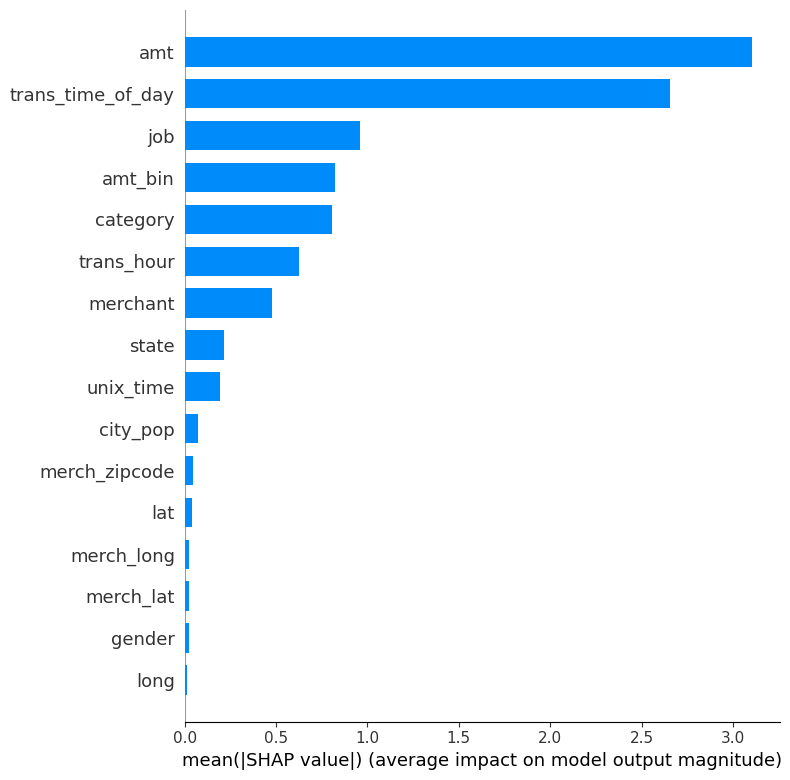

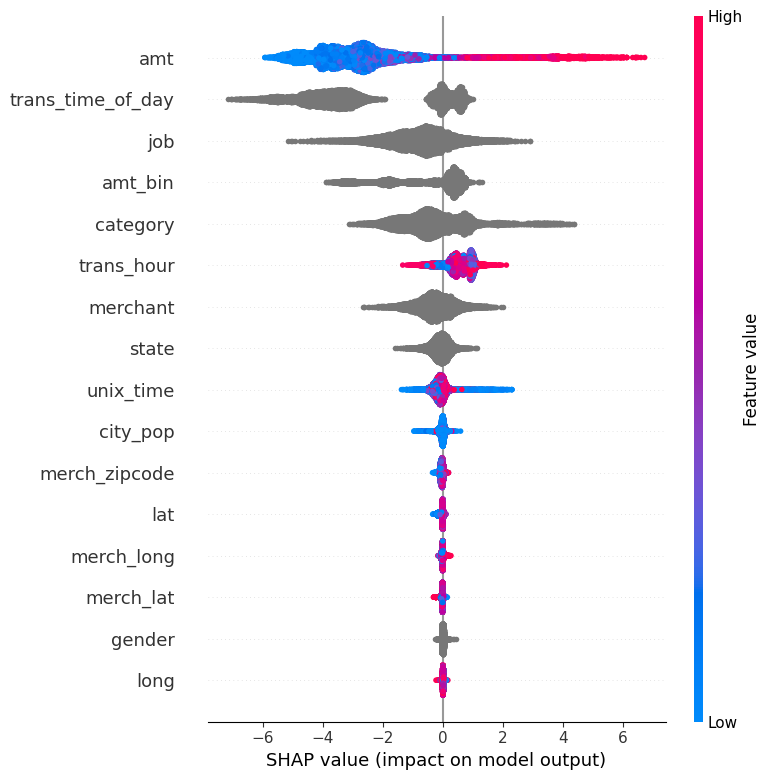

2025/10/07 12:44:32 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
C:\Users\User\anaconda3\envs\deepface\lib\site-packages\xgboost\sklearn.py:1028: UserWarning: [12:44:32] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\c_api\c_api.cc:1427: Saving model in the UBJSON format as default.  You can use file extension: `json`, `ubj` or `deprecated` to choose between formats.
  self.get_booster().save_model(fname)
2025/10/07 12:44:43 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


In [24]:
# SHAP Explanations
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_test)
shap.summary_plot(shap_values, X_test, plot_type="bar")
plt.savefig('shap_bar_xgb.png')
mlflow.log_artifact('shap_bar_xgb.png')
plt.close()
shap.summary_plot(shap_values, X_test)
plt.savefig('shap_summary_xgb.png')
mlflow.log_artifact('shap_summary_xgb.png')
plt.close()
plt.show()

# Log model
mlflow.xgboost.log_model(model, "xgb_model")

In [25]:
sample_indices = random.sample(range(len(X_test)), 10)
for i in sample_indices:
    print(f"Actual: {y_test.iloc[i]}, Predicted: {y_pred[i]}")

Actual: 0, Predicted: 0
Actual: 1, Predicted: 1
Actual: 0, Predicted: 0
Actual: 0, Predicted: 0
Actual: 0, Predicted: 0
Actual: 0, Predicted: 0
Actual: 0, Predicted: 0
Actual: 1, Predicted: 0
Actual: 0, Predicted: 0
Actual: 0, Predicted: 0


In [26]:
mlflow.end_run()